# LM 모델 활용하기

## 1. GPU 설정하기

In [1]:
# 1. GPU 사용 여부 확인
import torch

# 2. GPU 사용 가능 여부 확인
print(torch.cuda.is_available())        # True라면 GPU 사용 가능
print(torch.cuda.device_count())        # 사용 가능한 GPU 개수 출력
print(torch.cuda.get_device_name(0))    # 첫 번째 GPU 이름 출력
print(torch.cuda.empty_cache())         # cuda 메모리 초기화, 캐시 삭제

# 3. 디바이스 설정 (GPU가 없으면 CPU 사용)
device = torch.device(0)
print(f"Using device: {device}")

True
2
NVIDIA GeForce RTX 4090
None
Using device: cuda:0


## 2. 텍스트 생성 모델 설정 : KoGPT2, "skt/kogpt2-base-v2"

### 1) KoGPT2 모델 파인튜닝 전 텍스트 생성하기

In [3]:
from transformers import GPT2LMHeadModel, AutoTokenizer
from tqdm import tqdm

# 저장된 모델 및 토크나이저 로드
model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")
tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")

# 모델을 GPU로 이동
model.to("cuda")
model.eval()  # 평가 모드로 전환 (dropout 비활성화)

# 프롬프트 정의
prompt = "여유로움, 쓸쓸함, 안락함"

# 텍스트를 토큰화
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

# 텍스트 생성
output = model.generate(
    input_ids=input_ids,
    max_length=300,  # 생성할 텍스트의 최대 길이
    temperature=1.0,  # 창의성 제어 (높을수록 랜덤한 결과)
    top_k=200,  # 높은 확률의 k개 토큰만 고려
    top_p=0.95,  # 확률의 누적 합이 0.9 이하인 토큰만 고려
    repetition_penalty=1.2,  # 반복을 줄이기 위한 페널티
    do_sample=True,  # 샘플링 사용
    num_return_sequences=3 # 3개 문장 생성하기기
)

# 생성된 텍스트 디코딩
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

# 결과 출력
print("Generated Text:")
print(generated_text[:-1])
len(generated_text)

Generated Text:
여유로움, 쓸쓸함, 안락함 등이 있었다.
아이들은 더 이상 눈곱만큼도 묻지 않은 채 엄마의 뒷모습을 바라보고 있었다.
그러나 이런 아이들은 어른 못지 않게, 아이를 사랑하는데 익숙지 않았다.
부모는 아이에게 가까이 할 수 있는 것이 없었다.
그들의 모습에 놀랐다
하지만 그럴수록 아이는 엄마에게 키스를 하고 싶어졌다.
아이는 또래보다 엄마는 자신의 앞 모습만을 보고 자란다는 사실 때문에 울었다.
그러면서 아이들이 어렸을 때 엄마가 아이의 옆에 있으면 안 된다는 생각이 들었다.
엄마 없는 아이로 성장한 아이가 아빠를 만났을 때는 너무 끔찍한 것이었다.
우리 부부는 두 딸을 입양해 살았다.
30년이 훨씬 지난 지금 그들은 모두 건강하게 자라고 있다.
하지만 아직도 많은 부모들이 세 자녀를 키우는 것에 대해 망설이고 있을 것이다.
두 자녀와 네 가정이 현재 양육시스템에 적응하고 있다면 미래는 밝은 것 같지만, 그렇지 못하는 부모가 부지기수일 것이다.
더욱이, 지금의 장모가 아이들에게 집착하는 모습을 볼 때, 이들은 그 상황이 불쌍하기 짝이 없을 것이라고 믿었을지도 모른다.
지금 우리 사회는 무책임과 약자로 가득한 편이다.
잘못된 부모 교육은 비난받기 십상이다.
한때 성장 과정에 실패했던 사람들은 왜 그토록 자식을 키우려 하는가.
성장이 곧 부모의 책임이라고 말하면, 그들은 아직은 부족하다는 것을 인정해야 한다.
그리고 부모와 아이들의 관계를 부정적으로 바라보는 것은 잘못된 사실이다.
실제로 대부분의 사람들은 성장의 과정에도 책임이 있다고 생각한다.
성공적인 교육이나 좋은 일이 그렇게 많다고 해서 모두가 자신이 잘하는 것처럼 말할 수도 없겠지만, 교육의 결과는 또한 마찬가지로 나빠질 수밖에 없다


845

### 2) 노래 가사 처럼 출력하기 위한 Fine-Tuning Process

In [5]:
# 1. 모듈 불러오기
from transformers import AutoTokenizer, GPT2LMHeadModel, AdamW, get_scheduler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import torch

# 2. 모델 설정하기
model_name = "skt/kogpt2-base-v2"

# 3. 토크나이저 설정하기
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token # 패딩 토큰 설정

# 4. 데이터셋 클래스 정의
class LyricsDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        inputs["labels"] = inputs["input_ids"].clone()
        return {key: val.squeeze(0).to("cuda") for key, val in inputs.items()}

# 5. 수집 데이터 불러오기
csv_data = pd.read_csv(r"/home/wanted-1/potenup-workspace/Project/project2/team5/1.데이터모음/'music_data(Merge)'.csv")
lyrics_texts = csv_data["lyrics"]

# 6. 학습, 검증 데이터 분리
train_texts, val_texts = train_test_split(lyrics_texts, test_size=0.2, random_state=42)
train_dataset = LyricsDataset(train_texts, tokenizer)
val_dataset = LyricsDataset(val_texts, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# 7. 모델 로드 및 GPU로 이동
model = GPT2LMHeadModel.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))
model.to("cuda")
model.train()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51201, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51201, bias=False)
)

In [ ]:
# 8. 옵티마이저, 스케줄러 설정
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=500, num_training_steps=len(train_dataloader) * 3)
# 학습 루프
for epoch in range(10):
    total_train_loss = 0

    for batch in train_dataloader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_dataloader)

# 검증 과정
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["labels"])
            total_val_loss += outputs.loss.item()
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.2f}, Validation Loss: {avg_val_loss:.2f}")

### 3) Fine_tuned model 저장하기

In [2]:
# 모델 저장
model.save_pretrained("./fine_tuned_new_model")
tokenizer.save_pretrained("./fine_tuned_new_model")

('./fine_tuned_new_model/tokenizer_config.json',
 './fine_tuned_new_model/special_tokens_map.json',
 './fine_tuned_new_model/vocab.json',
 './fine_tuned_new_model/merges.txt',
 './fine_tuned_new_model/added_tokens.json',
 './fine_tuned_new_model/tokenizer.json')

### 4) Fine-tuning 학습 & 검증 과정 손실 시각화

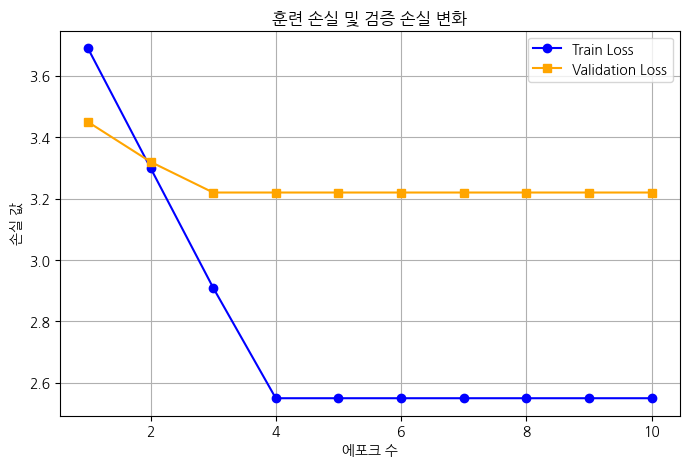

In [7]:
import koreanize_matplotlib
import matplotlib.pyplot as plt

# 예제 데이터 (Epoch별 Train Loss & Validation Loss)
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_losses = [3.69, 3.30, 2.91, 2.55, 2.55, 2.55, 2.55, 2.55, 2.55, 2.55]
val_losses = [3.45, 3.32, 3.22, 3.22, 3.22, 3.22, 3.22, 3.22, 3.22, 3.22]

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker='o', linestyle='-', label='Train Loss', color='blue')
plt.plot(epochs, val_losses, marker='s', linestyle='-', label='Validation Loss', color='orange')

# 그래프 제목 및 레이블 설정
plt.xlabel('에포크 수')
plt.ylabel('손실 값')
plt.title('훈련 손실 및 검증 손실 변화')
plt.legend()
plt.grid(True)

# 그래프 표시
plt.show()

## 3. 텍스트 생성

### 1) Fine-tuned 모델 사용하여 노래가사 10개 생성하기

In [12]:
from transformers import GPT2LMHeadModel, AutoTokenizer
import torch

# 1. 저장된 모델 및 토크나이저 로드
model = GPT2LMHeadModel.from_pretrained("./fine_tuned_new_model")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_new_model")

model.to("cuda")
model.eval()

# 2. 프롬프트 정의
prompt = "여유로움, 쓸쓸함, 안락함"

# 3. 텍스트 생성
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

with torch.no_grad():
    output = model.generate(
        input_ids=input_ids,
        max_length=150,  # 생성할 텍스트의 최대 길이 (토큰갯수 기준)
        temperature=0.9,  # 창의성 제어 (높을수록 랜덤한 결과)
        top_k=70,  # 높은 확률의 k개 토큰만 고려
        top_p=0.90,  # 확률의 누적 합이 0.9 이하인 토큰만 고려
        repetition_penalty=1.5,  # 반복을 줄이기 위한 페널티
        do_sample=True,  # 샘플링 사용
        num_return_sequences=1 # 10개 문장 생성하기기
    )

# 4. 생성된 텍스트 디코딩 및 출력
generated_texts = [tokenizer.decode(out, skip_special_tokens=True) for out in output]

print("\ngenerated_texts:")
for idx, text in enumerate(generated_texts):
    print(f"{idx+1}. {text}\n")


generated_texts:
1. 여유로움, 쓸쓸함, 안락함
그럴수록 내 안에 포근한 너는 필요해 넌 거기 있어 줄래야 사라지지 않아 나 어떡하면 될까
너에게 가는 발걸음은 마치 꽃처럼 다가오지만
여기 저기서 바라보는 네 눈빛은 너무나 따스해서 그 어떤 것도 나를 채울 수가 없어 
행복함을 아는 건 어쩌면 그리 쉬운 일이 아닐 거라 생각해
다 알면서도 나는 다 몰라, 난 정말 미안해, 이젠 다시 말할게 또 이상하지 않은 걸 알아서
다시 한번 말해볼게, 너무 행복하게 날 보내줘서 고마워, 우리 사이 좋아?
어느 새 한 번 더 널 바라보던 모습이 나의 맘을 적시네요 내가 사랑했던



In [13]:
generated_texts

['여유로움, 쓸쓸함, 안락함\n그럴수록 내 안에 포근한 너는 필요해 넌 거기 있어 줄래야 사라지지 않아 나 어떡하면 될까\n너에게 가는 발걸음은 마치 꽃처럼 다가오지만\n여기 저기서 바라보는 네 눈빛은 너무나 따스해서 그 어떤 것도 나를 채울 수가 없어 \n행복함을 아는 건 어쩌면 그리 쉬운 일이 아닐 거라 생각해\n다 알면서도 나는 다 몰라, 난 정말 미안해, 이젠 다시 말할게 또 이상하지 않은 걸 알아서\n다시 한번 말해볼게, 너무 행복하게 날 보내줘서 고마워, 우리 사이 좋아?\n어느 새 한 번 더 널 바라보던 모습이 나의 맘을 적시네요 내가 사랑했던']

### 2) 생성된 텍스트 평가 (BLEU, ROUGE, Perplexity)
- BLEU 점수: 생성된 텍스트와 원본 텍스트의 유사도를 측정
- ROUGE 점수: 생성된 텍스트와 원본 텍스트 간의 중복되는 단어 비율을 측정
- Perplexity: 모델의 언어 생성이 얼마나 자연스러운지 평가

In [14]:
from evaluate import load
import numpy as np

# 1. 평가 지표 불러오기
bleu = load("bleu")
rouge = load("rouge")

# 2. 테스트 데이터에서 일부 샘플 가져오기
num_samples = 10
test_samples = val_texts.sample(num_samples).tolist()

# 3. 모델 예측 및 평가
references = []
predictions = []

for sample in test_samples:
    input_ids = tokenizer(sample, return_tensors="pt", truncation=True, max_length=512).input_ids.to("cuda")
    
    with torch.no_grad():
        output = model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True)
    
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    
    references.append([sample])  # BLEU 평가는 다중 참조 가능하므로 리스트로 감싸기
    predictions.append(generated_text)

# 4. BLEU 점수 계산
bleu_score = bleu.compute(predictions=predictions, references=references)
print(f"BLEU Score: {bleu_score['bleu']:.4f}")

# 5. ROUGE 점수 계산
rouge_score = rouge.compute(predictions=predictions, references=references)
print(f"ROUGE Score: {rouge_score}")

# 6. Perplexity(혼란도) 계산
def compute_perplexity(model, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {key: value.to("cuda") for key, value in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])  # 🔥 labels 추가
    
    if outputs.loss is None:
        print("Warning: Model did not return a loss value.")
        return np.nan  # 오류 방지를 위해 NaN 반환
    
    loss = outputs.loss.item()
    return np.exp(loss)

perplexities = [compute_perplexity(model, text) for text in test_samples]
avg_perplexity = np.nanmean(perplexities)  # NaN 값 제외하고 평균 계산
print(f"Perplexity: {avg_perplexity:.4f}")

BLEU Score: 0.7642
ROUGE Score: {'rouge1': np.float64(0.3681172839506173), 'rouge2': np.float64(0.36971903982542276), 'rougeL': np.float64(0.370846875787352), 'rougeLsum': np.float64(0.37024313429075334)}
Perplexity: 18.9803


### 3) 생성된 텍스트의 BLEU, ROUGE, Perplexity 등의 결과 시각화

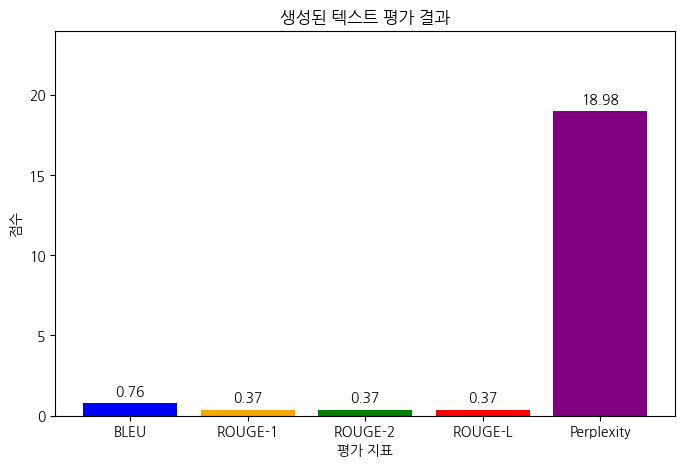

In [15]:
import numpy as np
import koreanize_matplotlib
import matplotlib.pyplot as plt

# 예제 데이터 (BLEU, ROUGE, Perplexity 평가 결과)
metrics = ["BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L", "Perplexity"]
scores = [float(f"{bleu_score['bleu']:.4f}"), float(f"{rouge_score['rouge1']}"), float(f"{rouge_score['rouge2']}"), float(f"{rouge_score['rougeL']}"), float(f"{avg_perplexity:.4f}")]  # 가상의 평가 점수

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['blue', 'orange', 'green', 'red', 'purple'])

# 그래프 제목 및 레이블 설정 (한글 적용)
plt.xlabel("평가 지표")
plt.ylabel("점수")
plt.title("생성된 텍스트 평가 결과")
plt.ylim(0, max(scores) + 5)  # y축 범위 조정

# 그래프 값 표시
for i, score in enumerate(scores):
    plt.text(i, score + 0.5, f"{score:.2f}", ha="center", fontsize=10)

# 그래프 표시
plt.show()

## 4. 텍스트 감성 분류 모델 설정 : KOTE, "searle-j/kote_for_easygoing_people"

### 1) 분류 기준 설정

In [30]:
# 1. 모듈 불러오기
import pandas as pd
from datasets import load_dataset
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

# 2. 토크나이저 및 모델 불러오기 
tokenizer = AutoTokenizer.from_pretrained("searle-j/kote_for_easygoing_people")
model = AutoModelForSequenceClassification.from_pretrained("searle-j/kote_for_easygoing_people")

# 3. 감성 분석 분류 기준 설정 
pipe = TextClassificationPipeline(
        model=model,
        tokenizer=tokenizer,
        device=0, # gpu number, -1 if cpu used
        return_all_scores=True,
        function_to_apply='sigmoid'
    )

Device set to use cuda:0
/home/wanted-1/miniconda3/envs/team5/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


### 2) 생성 된 가사 감성 분류하기

In [26]:
# 데이터 로드
text = generated_texts

# 긴 텍스트 자르기 함수
def truncate_texts(texts, tokenizer, max_length):   # 입력 텍스트 리스트를 받아, 각 텍스트를 최대 길이로 자르고 잘라낸 텍스트를 반환합니다.
    truncated_texts = []
    for t in texts:
        tokens = tokenizer(t, max_length=max_length, truncation=True)       #텍스트 t를 토큰화할 때, 최대 길이 max_length로 잘라내고 필요하면 truncation=True로 설정하여 초과 부분을 제거합니다.
        truncated_texts.append(tokenizer.decode(tokens['input_ids'], skip_special_tokens=True))     #잘라낸 토큰을 다시 텍스트로 변환하며, 특수 토큰은 제거합니다.
    return truncated_texts

# 텍스트 리스트를 잘라서 파이프라인에 전달
max_length = tokenizer.model_max_length  # 일반적으로 512
truncated_texts = truncate_texts(text, tokenizer, max_length)   # text 리스트의 각 텍스트를 최대 길이로 잘라냅니다.
pip_text = pipe(truncated_texts)        #잘라낸 텍스트를 파이프라인에 전달하여 감성 분석을 수행합니다.


# 결과 저장을 위한 리스트
results = []

# 각 감성에 해당할 확률(score)이 0.4 이상인 감성들만 저장
for i, t in enumerate(truncated_texts):            # 잘라낸 텍스트와 그에 대한 감성 분석 결과를 반복합니다.
    for output in pip_text[i]:
        if output["score"] > 0.4:
            results.append({
                "text": t,
                "label": output["label"],
                "score": output["score"]
            })

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)
results_df

# 데이터프레임 저장 
# results_df.to_csv("kote_result.csv", index=False)

# # 각 감성에 해당할 확률(score)이 0.4 이상인 감성들만 출력
# for i, t in enumerate(truncated_texts):     # 잘라낸 텍스트와 그에 대한 감성 분석 결과를 반복합니다.
#     print(f"Text: {t}")
#     for output in pip_text[i]:
#         if output["score"] > 0.4:
#             print(output)
#     print("\n")

,text,label,score
0,"여유로움, 쓸쓸함, 안락함 그럴수록 내 안에 포근한 너는 필요해 넌 거기 있어 줄래...",환영/호의,0.403206
1,"여유로움, 쓸쓸함, 안락함 그럴수록 내 안에 포근한 너는 필요해 넌 거기 있어 줄래...",감동/감탄,0.665159
2,"여유로움, 쓸쓸함, 안락함 그럴수록 내 안에 포근한 너는 필요해 넌 거기 있어 줄래...",고마움,0.826028
3,"여유로움, 쓸쓸함, 안락함 그럴수록 내 안에 포근한 너는 필요해 넌 거기 있어 줄래...",슬픔,0.718082
4,"여유로움, 쓸쓸함, 안락함 그럴수록 내 안에 포근한 너는 필요해 넌 거기 있어 줄래...",기대감,0.414624
5,"여유로움, 쓸쓸함, 안락함 그럴수록 내 안에 포근한 너는 필요해 넌 거기 있어 줄래...",편안/쾌적,0.556532
6,"여유로움, 쓸쓸함, 안락함 그럴수록 내 안에 포근한 너는 필요해 넌 거기 있어 줄래...",아껴주는,0.841833
7,"여유로움, 쓸쓸함, 안락함 그럴수록 내 안에 포근한 너는 필요해 넌 거기 있어 줄래...",힘듦/지침,0.494305
8,"여유로움, 쓸쓸함, 안락함 그럴수록 내 안에 포근한 너는 필요해 넌 거기 있어 줄래...",깨달음,0.503378
9,"여유로움, 쓸쓸함, 안락함 그럴수록 내 안에 포근한 너는 필요해 넌 거기 있어 줄래...",불쌍함/연민,0.464545
